In [1]:
import operator
# https://github.com/DEAP/deap/issues/491
import numpy as np
from deap import algorithms, base, creator, gp, tools
from scoop import futures
import pygraphviz as pgv
import matplotlib.pyplot as plt
import math
import imageio
import pickle
import argparse
import warnings
# warnings.simplefilter('ignore') 

In [2]:
############################################ Parameters ################################################
TARGET_EMOJI = 0 #@param "🦎"
MAX_HEIGHT = 15
APPLY_SOBEL_FILTER = False
VISION = 1
POPULATION = 250
TESTS_FOR_EACH_TREE = 1
N_TOTAL_STEPS = 20
GENS = 30
TARGET_IMG = np.full((25,25), .5)
SAVETO = None
RENDER = False

In [3]:
############################################ Test Images ################################################
def degrade_img():
    img = np.ones((25,25))
    for i in range(25):
        img[i][:] = 1 - (i*5)/100
    return img

def column_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if j == 12:
                img[i][j] = 1 - (i*5)/100
    return img

def plus_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if j == 12 or i == 12:
                img[i][j] = 0
    return img

def x_img():
    img = np.ones((25,25))
    for i in range(25):
        for j in range(25):
            if j == i or i + j == 24:
                img[i][j] = 0
    return img

def print_img(img):
    plt.figure(figsize=(4,4))
    plt.imshow(img, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
    plt.show()

In [4]:
############################################ Image Convertion functions ################################################
def to_rgb(x):
    # assume rgb premultiplied by alpha
    rgb, a = x[..., :3], to_alpha(x)
    return np.clip(1.0-a+rgb, 0, 0.9999)

def to_alpha(x):
    return np.clip(x[..., 3:4], 0, 0.9999)

def to_gray(x):
    rgb = to_rgb(x)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])


def load_emoji(index, path="data/emoji.png", size=40):
    im = imageio.imread(path)
    emoji = np.array(im[:, index*size:(index+1)*size].astype(np.float32))
    emoji /= 255.0
    gray_emoji = to_gray(emoji)
    return gray_emoji

def plot_loss(loss_log):
    plt.figure(figsize=(10, 4))
    plt.title('Loss history (log10)')
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.show()

def create_base_env(target_image):
    env = np.copy(target_image)
    env = np.pad(np.copy(target_image), 1)
    env[:] = 1
    a, b = env.shape
    env[int(a/2)][int(b/2)] = 0
    return env
    
def draw_graph(expr):
    nodes, edges, labels = gp.graph(expr)
    g = pgv.AGraph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)
    g.layout(prog="dot")

    for i in nodes:
        n = g.get_node(i)
        n.attr["label"] = labels[i]
    g.draw('out.png')

In [5]:
############################################ Automata  ################################################
sobel_x = [[-1, 0, +1], [-2, 0, +2], [-1, 0, +1]]
sobel_y = np.transpose(sobel_x)
class CA_2D_model:
    def __init__(self, length, width, individual, *, vision=VISION):
        self.individual = individual
        self.len = length + 2*vision
        self.wid = width + 2*vision
        self.vision = vision
        self.vision_size = (vision+2)**2

        # The size of the pad is dependent on how far each cell sees to updates its valus
        self.original = np.pad(np.zeros((length, width)),1)
        self.original[:] = 1    
        self.original[int(self.len/2)][int(self.wid/2)] = 0

        self.ca = np.copy(self.original)
    
    def reset_ca(self):
        self.ca = np.copy(self.original)

    def get_observation(self, i, j):
        observation = self.ca[i-self.vision:i+self.vision+1, j-self.vision:j+self.vision+1]
        if APPLY_SOBEL_FILTER and observation.shape == sobel_y.shape:
            x = np.multiply(sobel_x, observation) # apply sobel filter for edge detection
            y = np.multiply(sobel_y, observation) # apply sobel filter for edge detection
            return np.append(observation.reshape(-1), [x.reshape(-1), y.reshape(-1)])
        return observation.reshape(-1)

    def new_cell_value(self, i, j):
        if i-self.vision < 0 or j-self.vision < 0:
            return
        if i+self.vision >= self.len or j + self.vision >= self.wid:
            return

        observation = self.get_observation(i, j)
        if observation[0:self.vision_size].sum() >= 1 * self.vision_size: # checking if the cell is alive
            return 1.
        return self.individual(*observation)

    def update(self):
        new_ca = np.copy(self.ca)
        for i in range(self.vision, self.len - self.vision): # skipping pad
            for j in range(self.vision, self.wid - self.vision): # skipping pad
                new_ca[i, j] = self.new_cell_value(i, j)
        if (new_ca == self.ca).all(): # checking if the cell updated or not
            return False
        self.ca = new_ca
        return True

    def remove_pad(self):
        return self.ca[self.vision:self.len - self.vision, self.vision:self.wid - self.vision]

    def fitness(self, target_image):
        ca = self.remove_pad()
        if target_image.shape != ca.shape:
            raise
        loss = 0
        for i in range(target_image.shape[0]):
            for j in range(target_image.shape[1]):
                if ca[i,j] > 1 or ca[i,j] < 0 or math.isnan(ca[i,j]):
                    return -1000
                l = ca[i,j] - target_image[i,j]
                loss += l**2
        return 1 - loss

In [6]:
############################################ Creating GP and image ################################################
toolbox = base.Toolbox()
input_size = (VISION+2)**2
if APPLY_SOBEL_FILTER:
    input_size *= 3
pset = gp.PrimitiveSet("MAIN", input_size) 

############################################ Node Custom Operations ################################################

def protected_div(left, right):
    if right == 0:
        return 1
    return left / right
    
def limit(input, minimum, maximum):
    if input < minimum:
        return minimum
    elif input > maximum:
        return maximum
    else:
        return input

def if_then_else(input, output1, output2):
    if input: 
        return output1
    return output2

In [7]:
############################################ Creating the GP ################################################
def eval_individual(individual, render=False):
    shape = TARGET_IMG.shape
    ind = toolbox.compile(individual)
    ca = CA_2D_model(shape[0], shape[1], ind)
    
    total_fitness = 0.0
    for i in range(TESTS_FOR_EACH_TREE):
        ca.reset_ca()

        for _ in range(N_TOTAL_STEPS):
            if render:
                print_img(ca.remove_pad())
                print(ca.fitness(TARGET_IMG))
            update = ca.update()
            if not update: # the automata got stable
                break

        total_fitness += ca.fitness(TARGET_IMG)  

    fitness = (total_fitness / TESTS_FOR_EACH_TREE) 
    return (fitness,)


# Adding functions
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.abs, 1)
pset.addPrimitive(protected_div, 2)
pset.addPrimitive(limit, 3)
pset.addPrimitive(if_then_else, 3)
# Adding constants
pset.addTerminal(0)
pset.addTerminal(1)
pset.addTerminal(0.1)

creator.create("Fitness", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.Fitness)

# Tree generator
toolbox.register("tree_generator", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.tree_generator)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("map", futures.map)
toolbox.register("evaluate", eval_individual)
toolbox.register("select", tools.selTournament, tournsize=7)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(operator.attrgetter('height'), MAX_HEIGHT))
toolbox.decorate("mutate", gp.staticLimit(operator.attrgetter('height'), MAX_HEIGHT))

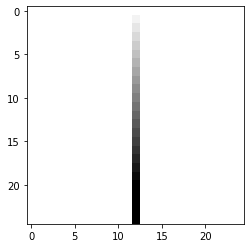

In [8]:
# TARGET_IMG = load_emoji(0, "data/stick.png", 25)
# TARGET_IMG = load_emoji(0, "data/brazil.png", 25)
TARGET_IMG = column_img()
# TARGET_IMG = plus_img()
# TARGET_IMG = degrade_img()
# TARGET_IMG = x_img()
# TARGET_IMG = load_emoji(command_line_args.img)
print_img(TARGET_IMG)

In [9]:
pop = toolbox.population(n=POPULATION)
hof = tools.HallOfFame(5)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.9, 0.3, GENS, stats=mstats,
                               halloffame=hof, verbose=True)

/home/k1/.local/lib/python3.8/site-packages/scoop/fallbacks.py:38: RuntimeWarning: SCOOP was not started properly.
Be sure to start your program with the '-m scoop' parameter. You can find further information in the documentation.
Your map call has been replaced by the builtin serial Python map().
  warnings.warn(
<string>:1: RuntimeWarning: overflow encountered in double_scalars
<string>:1: RuntimeWarning: invalid value encountered in double_scalars
/home/k1/.local/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/tmp/ipykernel_27670/2832359468.py:13: RuntimeWarning: invalid value encountered in double_scalars
  return left / right
/tmp/ipykernel_27670/2832359468.py:13: RuntimeWarning: overflow encountered in double_scalars
  return left / right
/home/k1/.local/lib/python3.8/site-packages/numpy/core/_methods.py:48: RuntimeWarning: overflow encountered in reduce
  r

   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min  	nevals	std    	avg   	gen	max	min	nevals	std    
0  	250   	-279.64	0  	-0.72	-1000	250   	403.771	16.056	0  	145	2  	250   	25.2664
1  	233   	-91.9105	1  	-0.72	-1000	233   	250.666	13.42 	1  	144	1  	233   	20.5639


KeyboardInterrupt: 

In [ ]:
halloffame = None
file = "testes/column_100g_25s.pkl"
cp = pickle.load(open(file, "rb"))
halloffame = cp["halloffame"]

In [ ]:
eval_individual(halloffame[-1], True)

In [ ]:
print_img(TARGET_IMG)